https://analyticsindiamag.com/complete-guide-to-dickey-fuller-test-in-time-series-analysis/

https://towardsdatascience.com/end-to-end-time-series-analysis-and-forecasting-a-trio-of-sarimax-lstm-and-prophet-part-1-306367e57db8

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import warnings


import itertools
import statsmodels.api as sm
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
from pmdarima.arima import nsdiffs
from pmdarima.arima import ndiffs
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('covid_clean_imputted.csv')

In [3]:
df.head()

,date,state,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,inpatient_beds,...,previous_day_admission_adult_covid_suspected_50-59,previous_day_admission_adult_covid_suspected_60-69,previous_day_admission_adult_covid_suspected_70-79,previous_day_admission_adult_covid_suspected_80+,previous_day_admission_adult_covid_suspected_unknown,deaths_covid,all_pediatric_inpatient_bed_occupied,all_pediatric_inpatient_beds,staffed_pediatric_icu_bed_occupancy,total_staffed_pediatric_icu_beds
0,2020-01-01,TX,0.0,0.0,3.0,0.0,0.0,3.0,0.0,790.0,...,0.0,0.0,0.0,0.0,2.2,0.0,5.2,59.8,0.0,0.2
1,2020-01-01,HI,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.2,0.0,12.6,27.6,0.0,0.0
2,2020-01-01,LA,0.0,0.0,1.0,0.0,0.0,1.0,0.0,41.2,...,0.0,0.0,0.0,0.0,0.0,0.0,136.4,150.6,40.6,46.0
3,2020-01-01,NC,0.0,0.0,1.0,0.0,0.0,1.0,0.0,72.0,...,0.0,0.0,0.0,0.0,0.0,0.0,14.0,45.6,0.0,0.0
4,2020-01-01,MN,0.0,0.0,1.0,0.0,0.0,1.0,0.0,46.0,...,0.0,0.0,0.0,0.0,0.0,0.0,14.0,45.6,0.0,0.0


In [418]:
df["date"] = pd.to_datetime(df['date'])#turning to dt object

In [419]:
df = df.set_index('date')#setting date as index. 

In [420]:
df_avg = df["deaths_covid"].resample("MS").mean() ##monthly

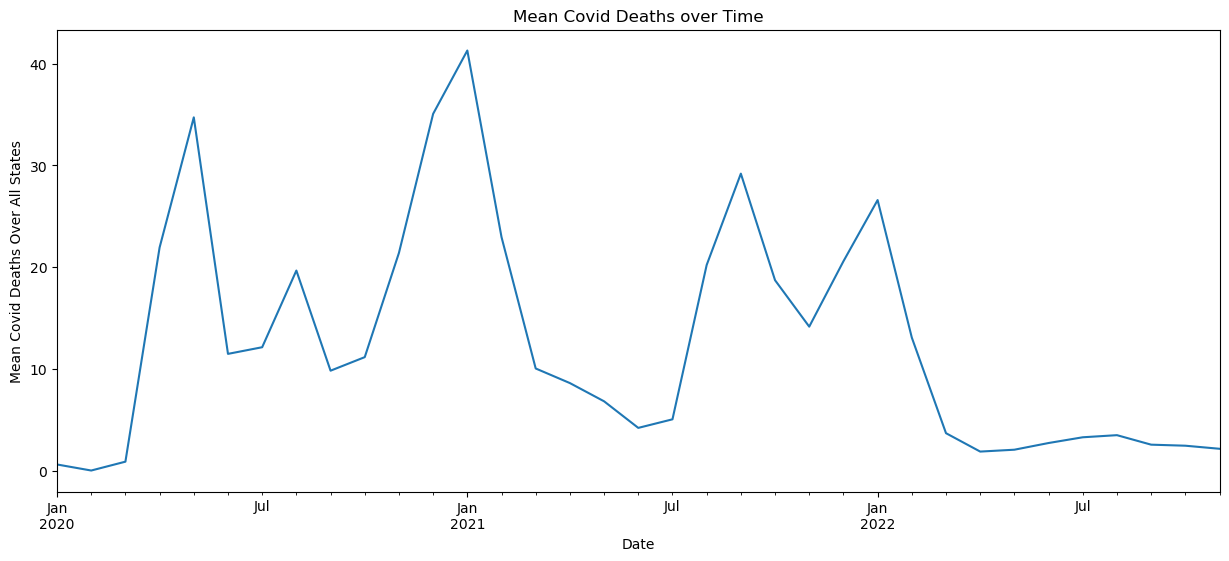

In [421]:
df_avg.plot(figsize = (15, 6))
plt.xlabel("Date")
plt.ylabel("Mean Covid Deaths Over All States")
plt.title("Mean Covid Deaths over Time")
plt.show()

##mean and variance may need to be adjusted for?

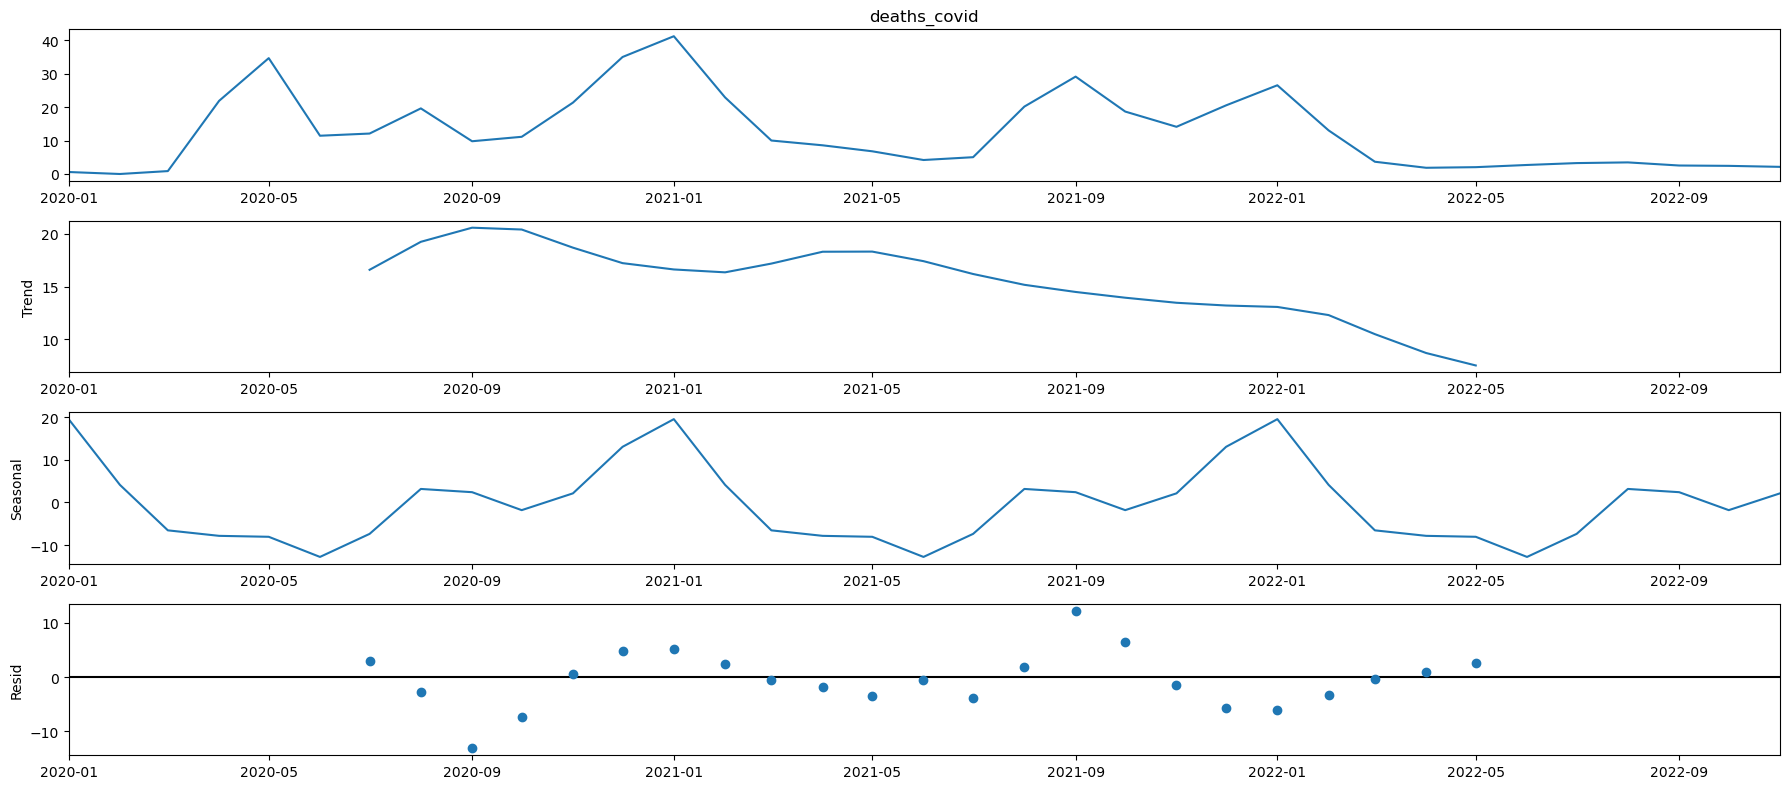

In [422]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_avg, model='additive')
fig = decomposition.plot()
plt.show()

In [383]:
### We need to strive for stationary

In [423]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[0] < dftest[4]["5%"]:
        return ("Reject Ho - Time Series is Stationary")
    else:
        return ("Failed to Reject Ho - Time Series is Non-Stationary")
print(adf_test(df_avg))

Results of Dickey-Fuller Test:
Test Statistic                 -0.126172
p-value                         0.946769
#Lags Used                      6.000000
Number of Observations Used    28.000000
Critical Value (1%)            -3.688926
Critical Value (5%)            -2.971989
Critical Value (10%)           -2.625296
dtype: float64
Failed to Reject Ho - Time Series is Non-Stationary


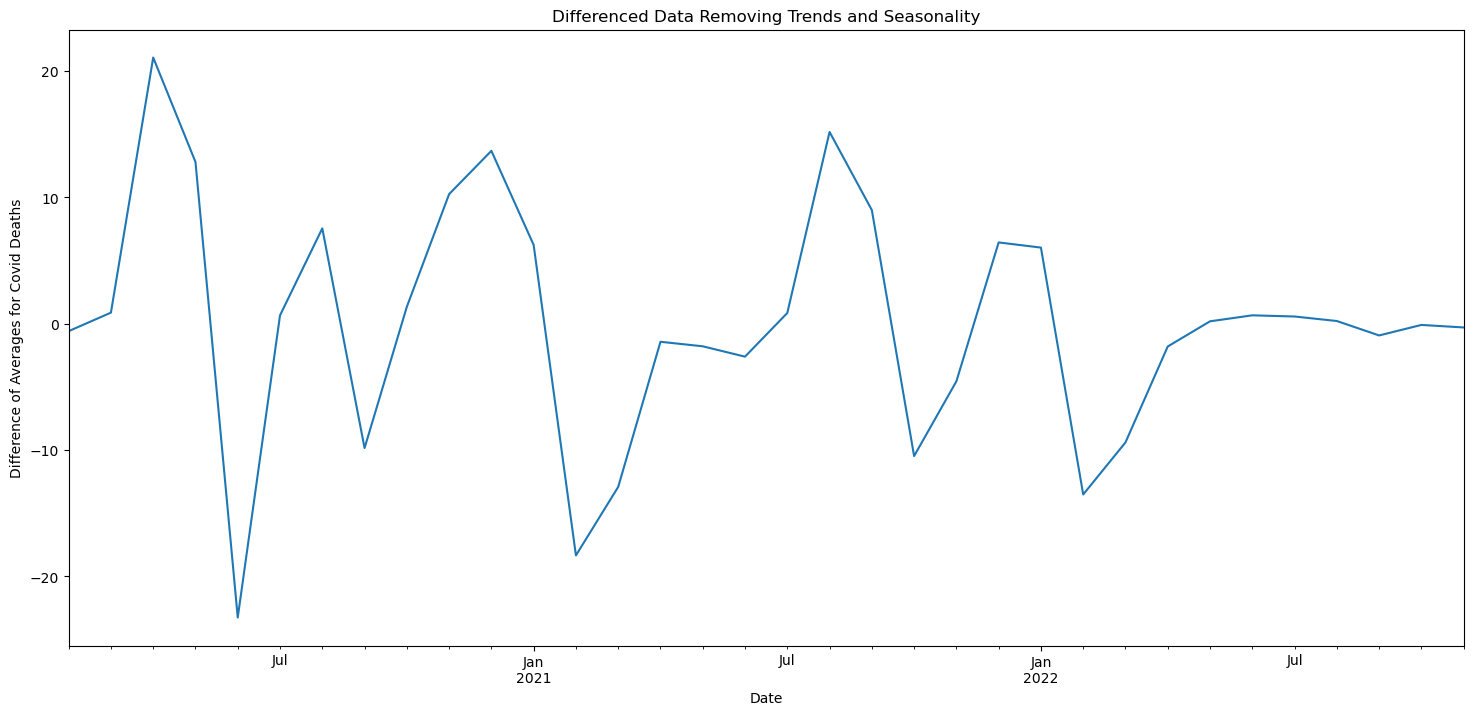

In [424]:
df_adj = df_avg - df_avg.shift(1)
df_adj = df_adj.dropna()
df_adj.plot()
plt.xlabel("Date")
plt.ylabel("Difference of Averages for Covid Deaths")
plt.title("Differenced Data Removing Trends and Seasonality")
plt.show()

In [425]:
print(adf_test(df_adj))

Results of Dickey-Fuller Test:
Test Statistic                 -5.160321
p-value                         0.000011
#Lags Used                      5.000000
Number of Observations Used    28.000000
Critical Value (1%)            -3.688926
Critical Value (5%)            -2.971989
Critical Value (10%)           -2.625296
dtype: float64
Reject Ho - Time Series is Stationary


In [215]:
#lets check if we need to account for seasonality

In [284]:
nsdiffs(df_adj,3)#doesn't seem like we need to account for seasonality

2

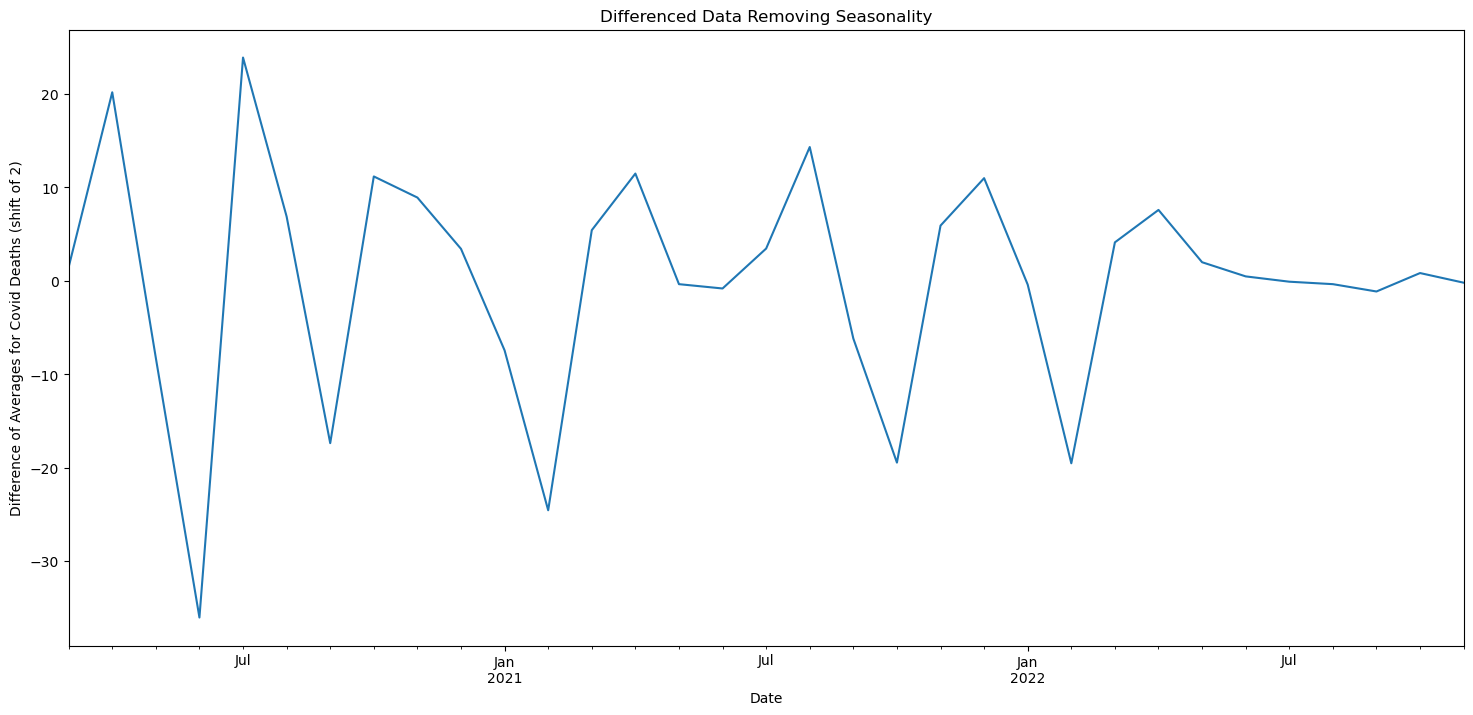

In [445]:
#we can test this model later
df_season_adj = df_adj - df_adj.shift(1)
df_season_adj = df_season_adj.dropna()
df_season_adj.plot()
plt.xlabel("Date")
plt.ylabel("Difference of Averages for Covid Deaths (shift of 2)")
plt.title("Differenced Data Removing Seasonality")
plt.show()

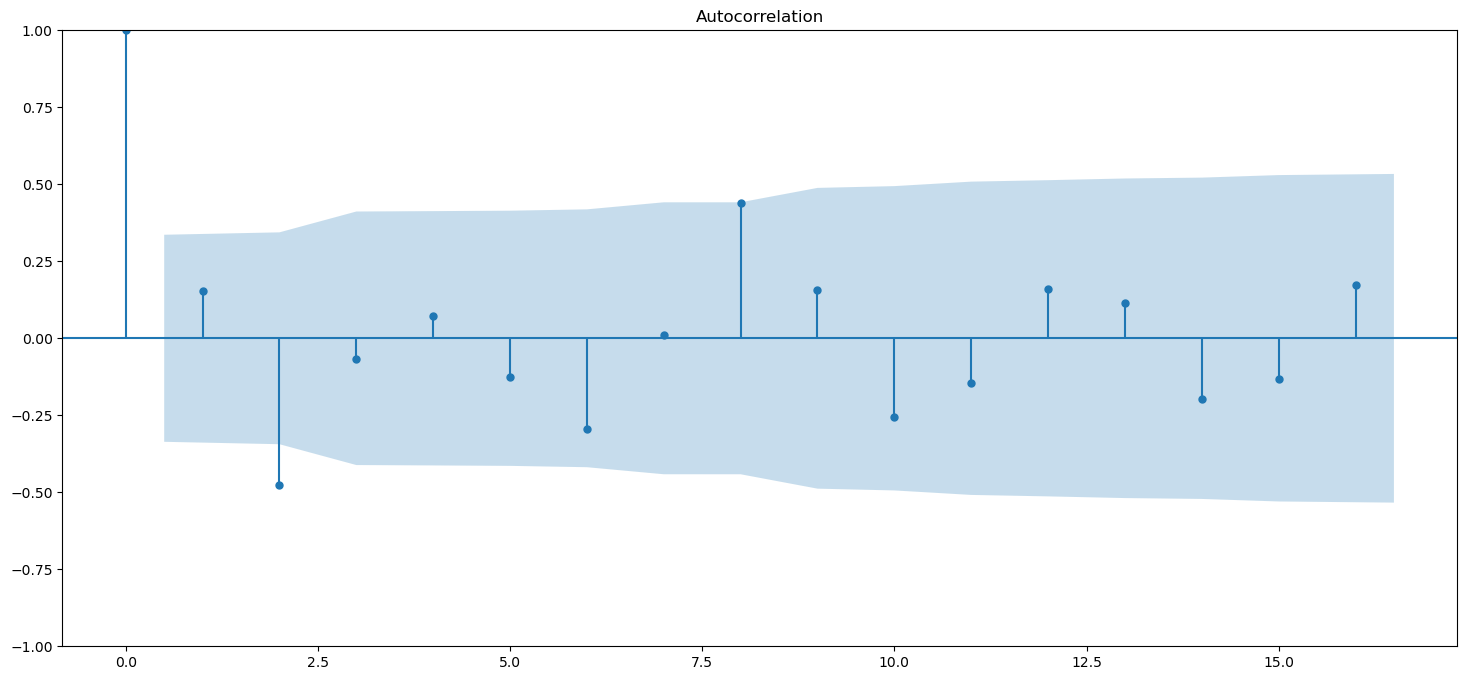

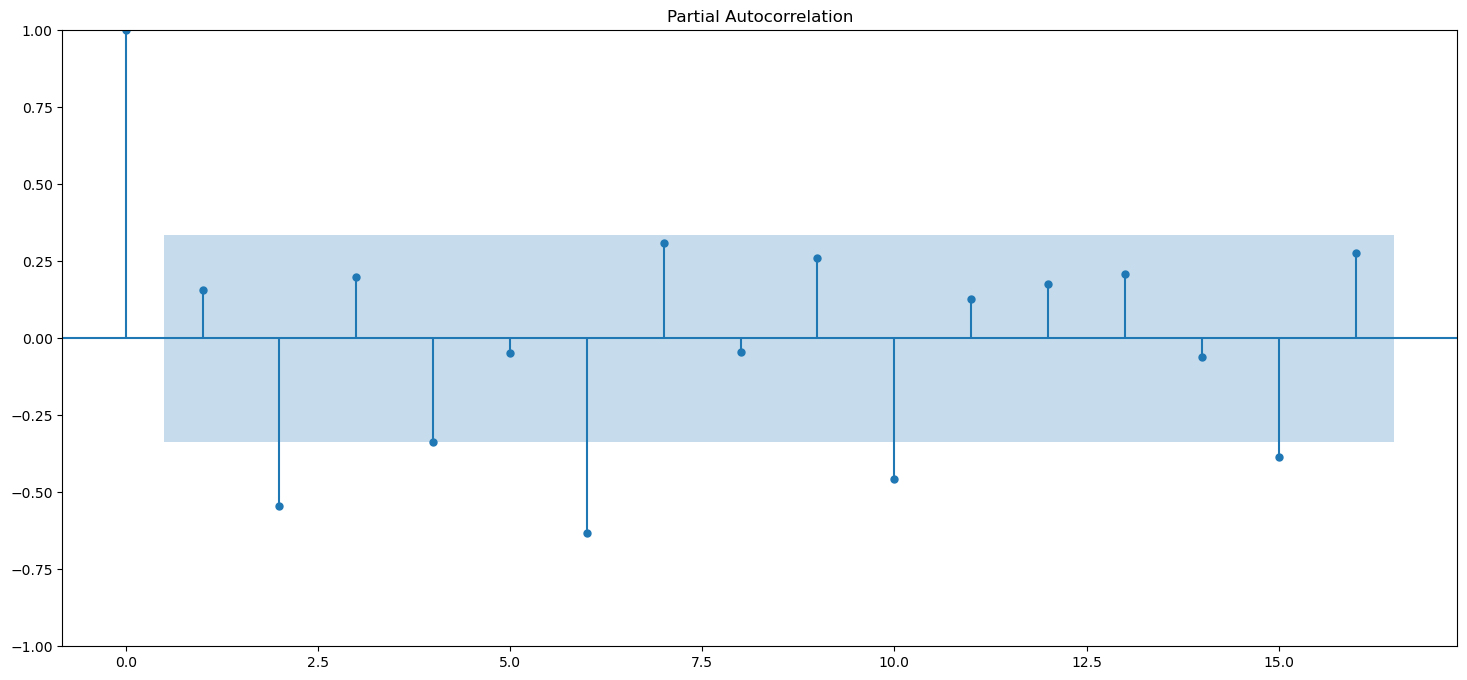

In [426]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_adj)
plt.show()
plot_pacf(df_adj)
plt.show()

In [427]:
p = range(0, 3)
d = range(1,2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_adj,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 2, 12)
SARIMAX: (0, 1, 2) x (1, 1, 0, 12)
SARIMAX: (0, 1, 2) x (1, 1, 1, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.42557D+00    |proj g|=  3.85654D-02

At iterate    5    f=  2.37660D+00    |proj g|=  2.10953D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      6      7      1     0     0   1.845D-07   2.377D+00
  F =   2.3766042773148928   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 1, 0)x(1, 1, 2, 12)12 - AIC:8.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(2, 1, 0, 12)12 - AIC:6.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.56450D-01    |proj g|=  1.66479D-02

At iterate    5    f=  9.31652D-01    |proj g|=  6.23804D-02

At iterate   10    f=  8.95294D-01    |proj g|=  7.65139D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     19      1     0     0   3.318D-06   8.952D-01
  F =  0.89523815489347236     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:66.87619453275613
RUNNING THE L-B

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 1, 1)x(2, 1, 1, 12)12 - AIC:10.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(2, 1, 2, 12)12 - AIC:12.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =          

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 1, 2)x(1, 1, 0, 12)12 - AIC:64.59243348796255
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.98282D-01    |proj g|=  2.89425D-01

At iterate    5    f=  5.69309D-01    |proj g|=  5.32378D-03

At iterate   10    f=  5.67315D-01    |proj g|=  2.07268D-03

At iterate   15    f=  5.67237D-01    |proj g|=  2.39289D-04

At iterate   20    f=  5.67219D-01    |proj g|=  1.38089D-03

At iterate   25    f=  5.67207D-01    |proj g|=  6.47087D-04

At iterate   30    f=  5.67203D-01    |proj g|=  2.28813D-04

At iterate   35    f=  5.67202D-01    |proj g|=  1.94845D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:10.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(2, 1, 1, 12)12 - AIC:12.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =          

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     16      1     0     0   5.106D-06   8.498D-01
  F =  0.84980307908222508     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:63.786609377591304
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.87269D-01    |proj g|=  7.52159D-02

At iterate    5    f=  8.75260D-01    |proj g|=  1.90491D-02

At iterate   10    f=  8.49871D-01    |proj g|=  1.66707D-03

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 1, 0)x(2, 1, 0, 12)12 - AIC:8.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(2, 1, 1, 12)12 - AIC:10.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 1, 1)x(0, 1, 2, 12)12 - AIC:10.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.60815D-01    |proj g|=  1.81370D-02

At iterate    5    f=  8.33487D-01    |proj g|=  1.17169D-02

At iterate   10    f=  8.03539D-01    |proj g|=  1.70950D-02

At iterate   15    f=  8.01989D-01    |proj g|=  1.46620D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     25      1     0     0   8.489D-07   8.020D-01
  F =  0.80198940433614918     

CONVERGENCE: NORM_OF_PROJEC

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(2, 1, 2, 12)12 - AIC:14.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 1, 2)x(0, 1, 2, 12)12 - AIC:12.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.74516D-01    |proj g|=  6.20074D-02

At iterate    5    f=  7.53937D-01    |proj g|=  8.80134D-03

At iterate   10    f=  7.48971D-01    |proj g|=  5.22439D-03

At iterate   15    f=  7.48865D-01    |proj g|=  3.89723D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     17      1     0     0   3.897D-06   7.489D-01
  F =  0.74886535871167836     

CONVERGENCE: NORM_OF_PROJEC

 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 1, 2)x(1, 1, 1, 12)12 - AIC:50.569593624775564
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 2)x(1, 1, 2, 12)12 - AIC:14.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 1, 2)x(2, 1, 2, 12)12 - AIC:16.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.19508D+00    |proj g|=  3.63403D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      0      1      0     0     0   3.634D-06   2.195D+00
  F =   2.1950799570346056     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(0, 1, 0, 12)12 - AIC:155.2654370783532
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  5.18217D-01    |proj g|=  3.21603D-01

At iterate   15    f=  4.71825D-01    |proj g|=  1.34108D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     41      1     0     0   2.601D-05   4.718D-01
  F =  0.47177081149416356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 0)x(1, 1, 0, 12)12 - AIC:40.08041518160312
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.51813D-01    |proj g|=  1.20375D-01

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(2, 1, 0)x(1, 1, 2, 12)12 - AIC:12.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(2, 1, 0, 12)12 - AIC:10.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =          

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     24      1     0     0   1.231D-05   2.139D+00
  F =   2.1394643139385492     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(0, 1, 0, 12)12 - AIC:153.48357334782133
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.35637D-01    |proj g|=  1.63316D-01

At iterate    5    f=  6.76254D-01    |proj g|=  4.39273D-02

At iterate   10    f=  6.43981D-01    |proj g|=  2.27299D-02

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.61947D-01    |proj g|=  5.79416D-02

At iterate   10    f=  5.96085D-01    |proj g|=  7.59239D-02

At iterate   15    f=  5.26692D-01    |proj g|=  3.28275D-02

At iterate   20    f=  5.01623D-01    |proj g|=  9.78265D-02

At iterate   25    f=  4.90811D-01    |proj g|=  1.31536D-01

At iterate   30    f=  4.82277D-01    |proj g|=  9.22550D-02

At iterate   35    f=  4.78216D-01    |proj g|=  1.67818D-02

At iterate   40    f=  4.76096D-01    |proj g|=  9.13950D-02

At iterate   45    f=  4.74642D-01    |proj g|=  8.15891D-02

At iterate   50    f=  4.73764D-01    |proj g|=  1.30817D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(2, 1, 1)x(1, 1, 2, 12)12 - AIC:14.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:12.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =          

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.99607D+00    |proj g|=  4.71347D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     26      1     0     0   4.713D-06   1.996D+00
  F =   1.9960693666434048     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 2)x(0, 1, 0, 12)12 - AIC:145.73271693175153
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.95195D-01    |proj g|=  2.17646D-01

At iterate    5    f=  4.74246D-01    |proj g|=  8.19396D-02

At iterate   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(2, 1, 2)x(0, 1, 2, 12)12 - AIC:14.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.66591D-01    |proj g|=  9.55123D-02

At iterate    5    f=  5.59449D-01    |proj g|=  1.11497D-01

At iterate   10    f=  5.06600D-01    |proj g|=  8.03160D-02

At iterate   15    f=  4.09994D-01    |proj g|=  6.59040D-01

At iterate   20    f=  4.04514D-01    |proj g|=  2.83187D-02

At iterate   25    f=  4.02771D-01    |proj g|=  2.01399D-01

At iterate   30    f=  4.02076D-01    |proj g|=  3.52359D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     87      2     0     0   5.476D-05   4.021D-01
  F =  0.40206202811603275     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 1, 2)x(1, 1, 0, 12)12 - AIC:39.34021791189023
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.95195D-01    |proj g|=  2.32139D-01

At iterate    5    f=  4.92946D-01    |proj g|=  3.10552D-02

At iterate   10    f=  4.52275D-01    |proj g|=  9.68468D-02

At iterate   1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 2)x(2, 1, 1, 12)12 - AIC:16.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly

 This problem is unconstrained.


In [257]:
#ARIMA(0, 1, 0)x(1, 1, 0, 12)12
#(0, 1, 0)x(0, 1, 2, 12)12

In [428]:
mod = sm.tsa.statespace.SARIMAX(df_adj,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12))
results = mod.fit(method = 'powell')
print(results.summary().tables[1])

Optimization terminated successfully.
         Current function value: 2.383477
         Iterations: 4
         Function evaluations: 250
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3215      0.653      0.493      0.622      -0.958       1.601
ma.L1         -0.9538      1.295     -0.736      0.461      -3.492       1.585
ar.S.L12      -0.3113    331.795     -0.001      0.999    -650.618     649.995
ma.S.L12      -0.0018    367.704  -5.01e-06      1.000    -720.689     720.685
sigma2       112.7072    126.121      0.894      0.372    -134.485     359.900


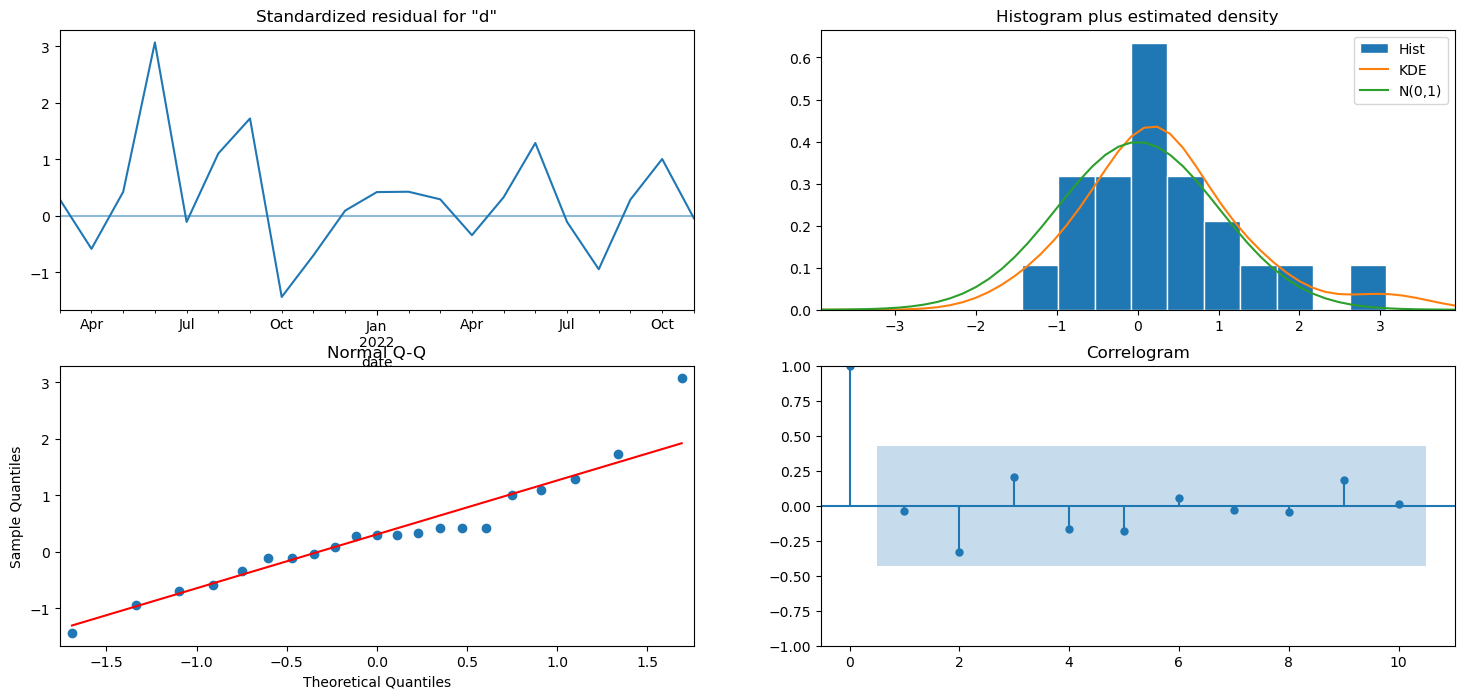

In [429]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

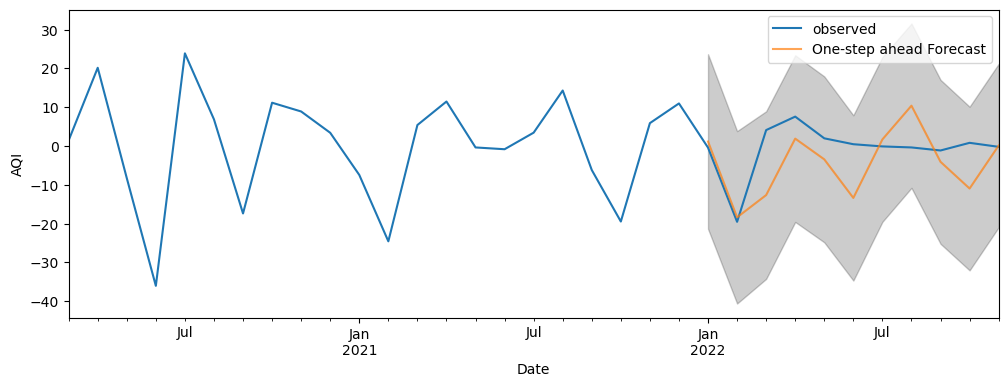

In [439]:
pred = results.get_prediction(start=pd.to_datetime('2022-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_season_adj.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(12, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('AQI')
plt.legend()
plt.show()

In [440]:
y_forecasted = pred.predicted_mean
y_truth = df_season_adj['2022-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 73.14
The Root Mean Squared Error is 8.55
